In [1]:
import json 
import os
import csv
import json
import sqlite3
import pydot
import numpy as np 
import pandas as pd
import tensorflow as tf
import seaborn as sns
import sqlite3
from pathlib import Path
from typing import Dict, Text
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow.keras as keras
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from operator import itemgetter
from sklearn import metrics
%matplotlib inline
np.random.seed=2022

In [2]:
def connect(path):
    con=sqlite3.connect(path)
    return con


def createQuery(query,connection):
    try:
        connection.cursor().execute(query)
        print('Table Created')
    except Exception as e:
        print('Exception',e)
        


#Function to perform get queries
def Query(query,connection):
    try:
        result=connection.cursor().execute(query)
        print('Query Executed')
        return result.fetchall()
    except Exception as e:
        print('Exception',e)

        
#Function to convert query(which comes in as a list of tuples to DataFrame)
def toDf(res,cols):
    try:
        return pd.DataFrame(res,columns=cols)
    except Exception as e:
        print(f'The DataFrame cannot be created because of this error: {e}')
        
### Get query Transformed ###

def getQuery(query,connection,cols):
    try:
        result=connection.cursor().execute(query)
        print('Query Executed')
        return toDf(result.fetchall(),cols)
    except Exception as e:
        print('Exception',e)

In [3]:
#Connection to database
connection=connect('../input/yelpdb/database.db')

In [4]:
# We perform an inner join on the buisness and reviews table to get all the users that rated a buisness
buisnessJoined=getQuery('select business_id, user_id, stars from reviews ',connection,['business_id','user_id','stars'])

Query Executed


In [5]:
# To get embedding we will require a unique and continious index or ids hence we use the following Transformations

#Taking Unique Users 
users = buisnessJoined.user_id.unique()
restraunts = buisnessJoined.business_id.unique()

# Creating a Reindexing Dictionary
userid2idx = {o:i for i,o in enumerate(users)}
restraunts2idx = {o:i for i,o in enumerate(restraunts)}

#Reindexing the Dataframe
buisnessJoined['business_id'] = buisnessJoined.business_id.apply(lambda x: restraunts2idx[x])
buisnessJoined['user_id'] = buisnessJoined.user_id.apply(lambda x: userid2idx[x])

#Getting Unique users which will give the number of embeddings required
nusers = buisnessJoined.user_id.nunique()
nrestraunts = buisnessJoined.business_id.nunique()
print(f'The number of Unique Users and Restraunts are {nusers}, {nrestraunts} respectively')


#Splitting Our Data into train and validation data
train_indices, val_indices = train_test_split(range(buisnessJoined.shape[0]), train_size=0.7)
trdf = buisnessJoined.iloc[train_indices]
valdf = buisnessJoined.iloc[val_indices]
print(f'The train and test dataset shapes are {trdf.shape}, {valdf.shape} respectively')

The number of Unique Users and Restraunts are 1617955, 63915 respectively
The train and test dataset shapes are (4265099, 3), (1827900, 3) respectively


In [6]:
valdf,test=train_test_split(valdf, train_size=0.5)

### Model Creation

In [52]:
# Creating Neural Networks Embedding
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

#We define latent space dimensions and regularization params
L = 18
L1=18
REG=8e-2

# We obtain the input placeholders as well as the embedding matrix for user and item
user_input, uLmat = embedding_input('user_input', nusers, L1, REG)
restraunts_input, rLmat = embedding_input('restraunts_input', nrestraunts, L, REG)

user_bias = create_bias('user_bias', user_input, nusers, REG)
restraunts_bias = create_bias('restraunts_bias', restraunts_input, nrestraunts, REG)



#Flatten embedding vectors

uLmatFlatten=tf.keras.layers.Flatten(name='UserEmbbeddingFlat')(uLmat)
rLmatFlatten=tf.keras.layers.Flatten(name='RestrauntsEmbbeddingFlat')(rLmat)

# Concatenate the the latent space
concat=tf.keras.layers.Concatenate(name='Concatenation',axis=1)([rLmatFlatten, uLmatFlatten])

#Multilayer Perceptron
drop1=tf.keras.layers.Dropout(0.5,name='DropoutLayer1')(concat)
dense1=tf.keras.layers.Dense(100,activation='relu',name='DenseLayer1',kernel_regularizer=tf.keras.regularizers.l2(1e-3))(drop1)
drop2=tf.keras.layers.Dropout(0.5,name='DropoutLayer2')(dense1)
dense2=tf.keras.layers.Dense(32,activation='relu',name='DenseLayer2')(drop2)
drop3=tf.keras.layers.Dropout(0.5,name='DropoutLayer3')(dense2)
dense3=tf.keras.layers.Dense(32,activation='relu',name='DenseLayer3')(drop3)
drop4=tf.keras.layers.Dropout(0.5,name='DropoutLayer4')(dense3)
dense4=tf.keras.layers.Dense(16,activation='relu',name='DenseLayer4')(drop4)


#Output
output=tf.keras.layers.Dense(1,name='OutputLayer')(dense3)
add=tf.keras.layers.Add()([user_bias,restraunts_bias,output])
activation=tf.keras.layers.Activation(activation='relu')(add)


model=tf.keras.Model([user_input,restraunts_input],activation)
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(0.0008))


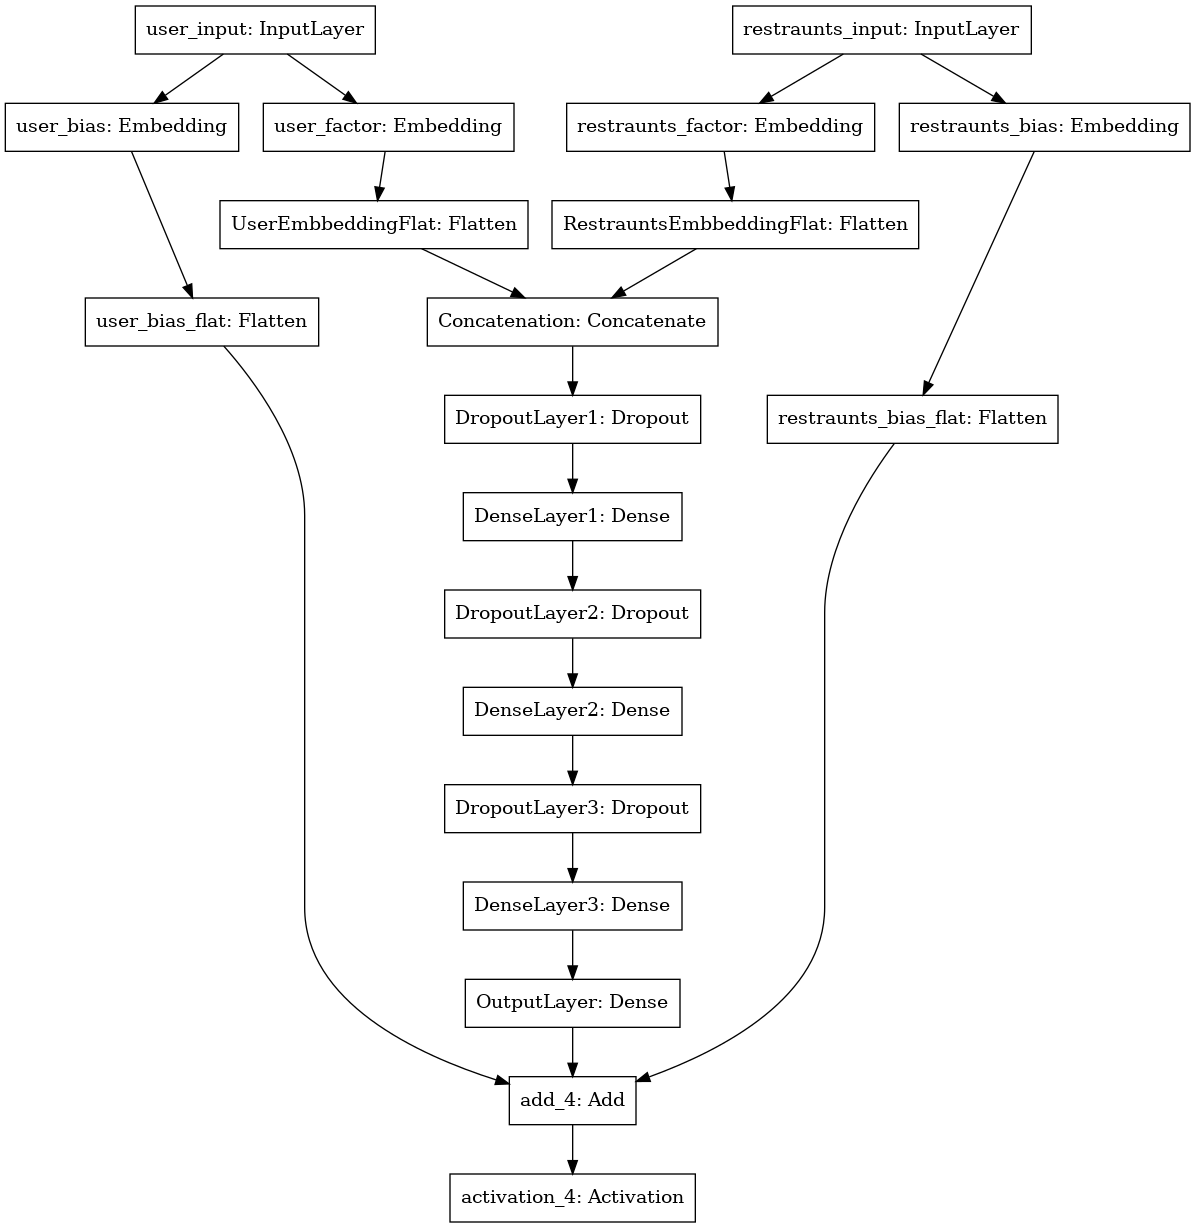

In [28]:
tf.keras.utils.plot_model(model)

In [53]:

#CheckPoint Model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='neuralmodel.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# model.load_weights(checkpoint_filepath)


In [54]:
#training our model 
history=model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=1024, epochs=15, validation_data=([valdf.user_id, valdf.business_id], valdf.stars),callbacks=[model_checkpoint_callback])

Epoch 1/15
4166/4166 [==============================] - 42s 10ms/step - loss: 10.4979 - val_loss: 1.6821
Epoch 2/15
4166/4166 [==============================] - 41s 10ms/step - loss: 1.5961 - val_loss: 1.5932
Epoch 3/15
4166/4166 [==============================] - 41s 10ms/step - loss: 1.4934 - val_loss: 1.5462
Epoch 4/15
4166/4166 [==============================] - 41s 10ms/step - loss: 1.4237 - val_loss: 1.5186
Epoch 5/15
4166/4166 [==============================] - 41s 10ms/step - loss: 1.3712 - val_loss: 1.5019
Epoch 6/15
4166/4166 [==============================] - 40s 10ms/step - loss: 1.3289 - val_loss: 1.4905
Epoch 7/15
4166/4166 [==============================] - 41s 10ms/step - loss: 1.2935 - val_loss: 1.4840
Epoch 8/15
4166/4166 [==============================] - 40s 10ms/step - loss: 1.2629 - val_loss: 1.4793
Epoch 9/15
4166/4166 [==============================] - 40s 10ms/step - loss: 1.2359 - val_loss: 1.4774
Epoch 10/15
4166/4166 [==============================] - 41s 10

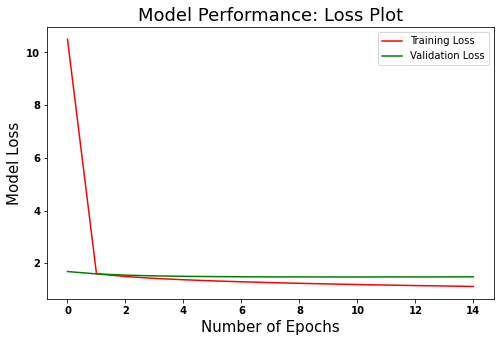

In [55]:
plt.rcParams['figure.figsize']=(8,5)
plt.plot(history.history['loss'],label='Training Loss',color='red')
plt.plot(history.history['val_loss'],label='Validation Loss',color='green')
plt.xticks(weight='bold',fontsize=10)
plt.yticks(weight='bold',fontsize=10)
plt.xlabel('Number of Epochs',fontsize=15)
plt.ylabel('Model Loss',fontsize=15)
plt.title('Model Performance: Loss Plot',fontsize=18)
plt.savefig('BaselineLoss.jpeg',dpi=200)
plt.legend()

In [58]:
print('The performance of our recommendation system on the dataset is as follows:')
pred=model.predict([valdf.user_id, valdf.business_id])
print(f'Validation loss of Neural Network {metrics.mean_squared_error(valdf.stars,pred)}')
pred=model.predict([trdf.user_id, trdf.business_id])
print(f'Trainig loss of Neural Network {metrics.mean_squared_error(trdf.stars,pred)}')
pred=model.predict([test.user_id, test.business_id])
print(f'Test loss of Neural Network {metrics.mean_squared_error(test.stars,pred)}')


The performance of our recommendation system on the dataset is as follows:
Validation loss of Neural Network 1.538690785166406
Trainig loss of Neural Network 1.0410307829094487
Test loss of Neural Network 1.5313136353698629


In [59]:
model_json = model.to_json()
with open("NeuralEmbeddingModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NeuralEmbeddingModel.h5")
print("Saved model to disk")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk
